In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from load_blender import load_blender_data
from run_nerf_helpers import *
from run_nerf_adv import My_args
from run_nerf_adv import *
from PIL import Image
from numpy import asarray
from torchvision.utils import save_image
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
import cv2

# default settings
torch.cuda.set_device(2)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.FloatTensor')
print(device)


# basic args and load data
args = My_args()
# args = My_args_llff()
K = None
if args.dataset_type == 'llff':
    images, poses, bds, render_poses, i_test = load_llff_data(args.datadir, args.factor,
                                                                recenter=True, bd_factor=.75,
                                                                spherify=args.spherify)
    hwf = poses[0,:3,-1]
    poses = poses[:,:3,:4]
    print('Loaded llff', images.shape, render_poses.shape, hwf, args.datadir)
    if not isinstance(i_test, list):
        i_test = [i_test]

    if args.llffhold > 0:
        print('Auto LLFF holdout,', args.llffhold)
        i_test = np.arange(images.shape[0])[::args.llffhold]

    i_val = i_test
    i_train = np.array([i for i in np.arange(int(images.shape[0])) if
                    (i not in i_test and i not in i_val)])

    print('DEFINING BOUNDS')
    if args.no_ndc:
        near = np.ndarray.min(bds) * .9
        far = np.ndarray.max(bds) * 1.
        
    else:
        near = 0.
        far = 1.
    print('NEAR FAR', near, far)

elif args.dataset_type == 'blender':
    images, poses, render_poses, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)
    print('Loaded blender', images.shape, render_poses.shape, hwf, args.datadir)
    i_train, i_val, i_test = i_split

    near = 2.
    far = 6.

    if args.white_bkgd:
        images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])
    else:
        images = images[...,:3]

elif args.dataset_type == 'LINEMOD':
    images, poses, render_poses, hwf, K, i_split, near, far = load_LINEMOD_data(args.datadir, args.half_res, args.testskip)
    print(f'Loaded LINEMOD, images shape: {images.shape}, hwf: {hwf}, K: {K}')
    print(f'[CHECK HERE] near: {near}, far: {far}.')
    i_train, i_val, i_test = i_split

    if args.white_bkgd:
        images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])
    else:
        images = images[...,:3]

elif args.dataset_type == 'deepvoxels':

    images, poses, render_poses, hwf, i_split = load_dv_data(scene=args.shape,
                                                                basedir=args.datadir,
                                                                testskip=args.testskip)

    print('Loaded deepvoxels', images.shape, render_poses.shape, hwf, args.datadir)
    i_train, i_val, i_test = i_split

    hemi_R = np.mean(np.linalg.norm(poses[:,:3,-1], axis=-1))
    near = hemi_R-1.
    far = hemi_R+1.

else:
    print('Unknown dataset type', args.dataset_type, 'exiting')
    # return

H, W, focal = hwf
H, W = int(H), int(W)
hwf = [H, W, focal]
K = np.array([
    [focal, 0, 0.5*W],
    [0, focal, 0.5*H],
    [0, 0, 1]
])

# adv_img
im = asarray(Image.open("adv/dogs.png").resize((400,400)))
im32 = im.astype(np.float32) / 255.
adv_img = torch.tensor(im32).to(device)
plt.figure(figsize=(10, 4))
plt.imshow(adv_img.detach().cpu().numpy())
plt.show()

# Create log dir and copy the config file
basedir = args.basedir
expname = 'flower_test'
os.makedirs(os.path.join(basedir, expname), exist_ok=True)
# Create nerf model
near = 2.
far = 6.

# Move testing data to GPU
poses = torch.Tensor(poses).to(device)
# show the target_img
target_pose, target_img = poses[5], images[5]
c2w=target_pose[:3,:4]
plt.axis('off')
plt.imshow(target_img)
plt.savefig("plot.png")
plt.show()

: 

In [4]:
N_thresh = 6144
Loop = 300
# target image
target = images[5]
target = torch.Tensor(target).to(device)
net = get_pretrained_net(args)
# get all encoded points
rays_o_all, rays_d_all, viewdirs_all, z_vals_all, points_all = get_points(H, W, K, rays=None, c2w=c2w, near=near, far=far, use_viewdirs=args.use_viewdirs, N_samples=args.N_samples, args=args)
rays_o_all_copy, rays_d_all_copy, viewdirs_all_copy, z_vals_all_copy, points_all_copy = get_points(H, W, K, rays=None, c2w=c2w, near=near, far=far, use_viewdirs=args.use_viewdirs, N_samples=args.N_samples, args=args)
# show_image(viewdirs_all, z_vals_all, rays_o_all, rays_d_all, encoded_points_all, net, args, chunk=1024*64)

coords = torch.stack(torch.meshgrid(torch.linspace(0, H-1, H), torch.linspace(0, W-1, W)), -1)
coords = torch.reshape(coords, [-1,2])  # (H * W, 2)


for num, i in enumerate(range(0, W*H, N_thresh)):
    rays_o, rays_d = get_rays(H, W, K, c2w)
    i = 0
    if N_thresh+i-1 > W*H-1:
        select_inds = torch.linspace(i, W*H-1, N_thresh).long()  # (N_rand,)
    else:
        select_inds = torch.linspace(i, N_thresh+i-1, N_thresh).long()  # (N_rand,)
    select_coords = coords[select_inds].long()  # (N_rand, 2)
    rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    viewdirs = viewdirs_all.reshape((400,400,-1))[select_coords[:, 0], select_coords[:, 1]] # (N_rand, 3)
    z_vals = z_vals_all.reshape((400,400,-1))[select_coords[:, 0], select_coords[:, 1]] # (N_rand, 64)

    # target and adv img
    target_s = target[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    adv_img_s = adv_img[select_coords[:, 0], select_coords[:, 1]] # (N_rand, 3)

    # points
    points = points_all.reshape((400,400,64,3))[select_coords[:, 0], select_coords[:, 1]].reshape((-1,64,3))
    points.requires_grad = True
    lr = 1e-2
    weight_decay=8e-1
    decay_rate = 0.3
    adv_optimizer = torch.optim.AdamW([points], lr=lr, weight_decay=weight_decay)
    # adv_optimizer = torch.optim.Adam([encoded_points], lr=lr)
    # adv_optimizer = torch.optim.SGD([encoded_points], lr=8e-1, momentum=0.1)
    adv_points = points.clone()
    global_step = 1
    loss_list = []
    for j in range(Loop): # 主要在这里加trick，以梯度值作为指标。

        # if j < 50:
        #     lr = 1e-1
        # else:
        #     lr = 1e-2
        adv_optimizer.param_groups[0]['lr'] = lr
        
        sh = rays_d.shape
        rgb, disp, acc, extras = encoded_render(viewdirs, z_vals, rays_o, rays_d, adv_points, net, sh, chunk=1024*64, args=args)

        loss = torch.nn.functional.mse_loss(rgb, adv_img_s, reduction='sum')
        loss_list.append(loss.item())
        # loss = torch.nn.functional.smooth_l1_loss(rgb, adv_img_s)
        # print('img_loss', loss)
        loss.backward()
        adv_optimizer.step()
        adv_optimizer.zero_grad()
        adv_points = adv_optimizer.param_groups[0]['params'][0]

        # ###   update learning rate and weight_decay  ###
        new_lrate = lr * (decay_rate ** (global_step / Loop))
        for param_group in adv_optimizer.param_groups:
            param_group['lr'] = new_lrate

        new_weight_decay = weight_decay * (decay_rate ** (global_step / Loop))
        for param_group in adv_optimizer.param_groups:
            param_group['weight_decay'] = new_weight_decay


        global_step = global_step + 1
        # #################################################
    file = open("record/"+str(num+1)+".txt", "w")
    for cont, item in enumerate(loss_list):
        file.write(str(cont+1) + "\t" + str(item) + "\n")
    file.close()

    print(num+1, 'img_loss', loss)
    points.requires_grad = False
    points_all.reshape((400,400,64,3))[select_coords[:, 0], select_coords[:, 1]] = adv_points

Reloading from ./logs/blender_lego/130000.tar
1 img_loss tensor(752.9886, grad_fn=<MseLossBackward0>)
2 img_loss tensor(625.0471, grad_fn=<MseLossBackward0>)
3 img_loss tensor(977.7769, grad_fn=<MseLossBackward0>)
4 img_loss tensor(1200.6978, grad_fn=<MseLossBackward0>)
5 img_loss tensor(1293.7384, grad_fn=<MseLossBackward0>)
6 img_loss tensor(1304.3677, grad_fn=<MseLossBackward0>)
7 img_loss tensor(1295.6848, grad_fn=<MseLossBackward0>)
8 img_loss tensor(1257.5845, grad_fn=<MseLossBackward0>)
9 img_loss tensor(1181.1871, grad_fn=<MseLossBackward0>)
10 img_loss tensor(1100.5134, grad_fn=<MseLossBackward0>)
11 img_loss tensor(994.4377, grad_fn=<MseLossBackward0>)
12 img_loss tensor(913.8925, grad_fn=<MseLossBackward0>)
13 img_loss tensor(837.9371, grad_fn=<MseLossBackward0>)
14 img_loss tensor(758.2534, grad_fn=<MseLossBackward0>)
15 img_loss tensor(687.2232, grad_fn=<MseLossBackward0>)
16 img_loss tensor(625.4538, grad_fn=<MseLossBackward0>)
17 img_loss tensor(555.8589, grad_fn=<MseLos

In [ ]:
noise = points_all - points_all_copy
# torch.save(noise, 'result/'+'Local_'+str(N_thresh)+'_opt_'+str(Loop)+'.pt')
sh = torch.ones((W,H,3)).shape
with torch.no_grad():
    my_adv_img, disp, acc, extras = encoded_render(viewdirs_all_copy, z_vals_all_copy, rays_o_all_copy, rays_d_all_copy, points_all_copy, net, sh, args=args, chunk=1024*64)
# save_image(torch.permute(my_adv_img, (2, 0, 1)),'result/'+'Local_'+str(N_thresh)+'_opt_'+str(Loop)+'.png')
save_image(torch.permute(my_adv_img, (2, 0, 1)),'zzzz.png')

print("ssim =", ssim(my_adv_img.cpu().numpy(), adv_img.cpu().numpy(), multichannel=True))
plt.imshow(my_adv_img.cpu().numpy())
plt.show()

RuntimeError: The expanded size of the tensor (160000) must match the existing size (65536) at non-singleton dimension 0.  Target sizes: [160000, 64, 3].  Tensor sizes: [65536, 1, 3]

In [5]:
viewdirs = viewdirs_all[0:0+1024*64]
inputs_flat = torch.reshape(points_all_copy, [-1, points_all_copy.shape[-1]])[0:0+1024*64]
viewdirs[:,None].shape#.expand(inputs_flat.shape)
viewdirs.shape, inputs_flat.shape

(torch.Size([65536, 3]), torch.Size([65536, 3]))

In [5]:
N_thresh = 6144
Loop = 600
# target image
target = images[5]
target = torch.Tensor(target).to(device)
net = get_pretrained_net(args)
# get all encoded points
rays_o_all, rays_d_all, viewdirs_all, z_vals_all, encoded_points_all = get_points(H, W, K, rays=None, c2w=c2w, near=near, far=far, use_viewdirs=args.use_viewdirs, N_samples=args.N_samples, args=args)
rays_o_all_copy, rays_d_all_copy, viewdirs_all_copy, z_vals_all_copy, encoded_points_all_copy = get_points(H, W, K, rays=None, c2w=c2w, near=near, far=far, use_viewdirs=args.use_viewdirs, N_samples=args.N_samples, args=args)
# show_image(viewdirs_all, z_vals_all, rays_o_all, rays_d_all, encoded_points_all, net, args, chunk=1024*64)

coords = torch.stack(torch.meshgrid(torch.linspace(0, H-1, H), torch.linspace(0, W-1, W)), -1)
coords = torch.reshape(coords, [-1,2])  # (H * W, 2)

# for i in tqdm(range(0, W*H, N_thresh)):
# for num, i in enumerate(tqdm(range(0, W*H, N_thresh))):
for num, i in enumerate(range(0, W*H, N_thresh)):
    # loop through all pixels 每个像素是肯定要循环的，不然不更新了。

    rays_o, rays_d = get_rays(H, W, K, c2w)
    if N_thresh+i-1 > W*H-1:
        select_inds = torch.linspace(i, W*H-1, N_thresh).long()  # (N_rand,)
    else:
        select_inds = torch.linspace(i, N_thresh+i-1, N_thresh).long()  # (N_rand,)
    select_coords = coords[select_inds].long()  # (N_rand, 2)
    rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    viewdirs = viewdirs_all.reshape((400,400,-1))[select_coords[:, 0], select_coords[:, 1]] # (N_rand, 3)
    z_vals = z_vals_all.reshape((400,400,-1))[select_coords[:, 0], select_coords[:, 1]] # (N_rand, 64)
    
    # target and adv img
    target_s = target[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    adv_img_s = adv_img[select_coords[:, 0], select_coords[:, 1]] # (N_rand, 3)
    
    # encoded_points
    encoded_points = encoded_points_all.reshape((400,400,64,90))[select_coords[:, 0], select_coords[:, 1]].reshape((-1,64,90))
    encoded_points.requires_grad = True

    # adversarial attacking
    lr = 1e-2
    weight_decay=8e-1
    decay_rate = 0.3
    adv_optimizer = torch.optim.AdamW([encoded_points], lr=lr, weight_decay=weight_decay)
    # adv_optimizer = torch.optim.Adam([encoded_points], lr=lr)
    # adv_optimizer = torch.optim.SGD([encoded_points], lr=8e-1, momentum=0.1)
    adv_points = encoded_points.clone()
    global_step = 1
    loss_list = []
    for j in range(Loop): # 主要在这里加trick，以梯度值作为指标。

        if j < 50:
            lr = 1e-1
        else:
            lr = 1e-2
        adv_optimizer.param_groups[0]['lr'] = lr
        
        sh = rays_d.shape
        rgb, disp, acc, extras = encoded_render_new(viewdirs, z_vals, rays_o, rays_d, adv_points, net, sh, chunk=1024*64, args=args)

        loss = torch.nn.functional.mse_loss(rgb, adv_img_s, reduction='sum')
        loss_list.append(loss.item())
        # loss = torch.nn.functional.smooth_l1_loss(rgb, adv_img_s)
        # print('img_loss', loss)
        loss.backward()
        adv_optimizer.step()
        adv_optimizer.zero_grad()
        adv_points = adv_optimizer.param_groups[0]['params'][0]

        # ###   update learning rate and weight_decay  ###
        new_lrate = lr * (decay_rate ** (global_step / Loop))
        for param_group in adv_optimizer.param_groups:
            param_group['lr'] = new_lrate

        new_weight_decay = weight_decay * (decay_rate ** (global_step / Loop))
        for param_group in adv_optimizer.param_groups:
            param_group['weight_decay'] = new_weight_decay


        global_step = global_step + 1
        # #################################################

    print(num+1, 'img_loss', loss)
    encoded_points.requires_grad = False
    encoded_points_all.reshape((400,400,64,90))[select_coords[:, 0], select_coords[:, 1]] = adv_points

Reloading from ./logs/blender_lego/130000.tar


/home/qhuang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  # Remove the CWD from sys.path while we load stuff.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ssim = 0.40333423


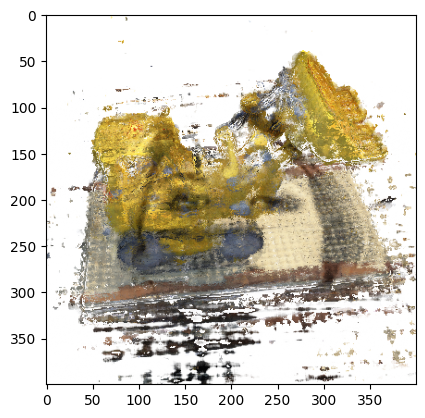

In [ ]:
noise = encoded_points_all - encoded_points_all_copy
# torch.save(noise, 'result/'+'Local_'+str(N_thresh)+'_opt_'+str(Loop)+'.pt')

sh = torch.ones((W,H,3)).shape
with torch.no_grad():
    my_adv_img, disp, acc, extras = encoded_render_new(viewdirs_all_copy, z_vals_all_copy, rays_o_all_copy, rays_d_all_copy, encoded_points_all_copy+noise, net, sh, args=args, chunk=1024*64)
# save_image(torch.permute(my_adv_img, (2, 0, 1)),'result/'+'Local_'+str(N_thresh)+'_opt_'+str(Loop)+'.png')
save_image(torch.permute(my_adv_img, (2, 0, 1)),'zzzz.png')

print("ssim =", ssim(my_adv_img.cpu().numpy(), adv_img.cpu().numpy(), multichannel=True))
plt.imshow(my_adv_img.cpu().numpy())
plt.show()

In [ ]:
ray_origins, ray_directions = get_rays(H, W, K, target_pose[:3,:4])
viewdirs = ray_directions
viewdirs = viewdirs / torch.norm(viewdirs, dim=-1, keepdim=True)
viewdirs = torch.reshape(viewdirs, [-1,3]).float()
sh = ray_directions.shape # [..., 3]

# Create ray batch
ray_origins = torch.reshape(ray_origins, [-1,3]).float()
ray_directions = torch.reshape(ray_directions, [-1,3]).float()
near, far = near * torch.ones_like(ray_directions[...,:1]), far * torch.ones_like(ray_directions[...,:1])
rays = torch.cat([ray_origins, ray_directions, near, far], -1)
rays_flat = torch.cat([rays, viewdirs], -1)
print('rays_flat shape', rays_flat.shape)
chunk = 1024*64


with torch.no_grad():
    all_ret = {}
    for i in range(0, rays_flat.shape[0], chunk):
        ray_batch = rays_flat[i:i+chunk]
        N_rays = ray_batch.shape[0]
        rays_o, rays_d = ray_batch[:,0:3], ray_batch[:,3:6]
        viewdirs = ray_batch[:,-3:]
        bounds = torch.reshape(ray_batch[...,6:8], [-1,1,2])
        near, far = bounds[...,0], bounds[...,1] # [-1,1]
        N_samples = render_kwargs_test['N_samples']
        t_vals = torch.linspace(0., 1., steps=N_samples)
        z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))
        z_vals = z_vals.expand([N_rays, N_samples])
        pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples, 3]

        # raw = my_query(pts, viewdirs, render_kwargs_test['network_fn'], embed_fn, embeddirs_fn, args)
        embedded = get_embeded(pts, viewdirs, embed_fn, embeddirs_fn)
        raw = my_query(pts, embedded, render_kwargs_test['network_fn'], args)
        rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(raw, z_vals, rays_d, args.raw_noise_std, args.white_bkgd)
        
        if render_kwargs_test['N_importance'] > 0:
            N_importance = render_kwargs_test['N_importance']
            # rgb_map_0, disp_map_0, acc_map_0 = rgb_map, disp_map, acc_map

            z_vals_mid = .5 * (z_vals[...,1:] + z_vals[...,:-1])
            z_samples = sample_pdf(z_vals_mid, weights[...,1:-1], N_importance)
            z_samples = z_samples.detach()
            z_vals, _ = torch.sort(torch.cat([z_vals, z_samples], -1), -1)
            pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples + N_importance, 3]

            # raw = my_query(pts, viewdirs, render_kwargs_test['network_fine'], embed_fn, embeddirs_fn, args)
            embedded = get_embeded(pts, viewdirs, embed_fn, embeddirs_fn)
            # print(embedded.shape)
            raw = my_query(pts, embedded, render_kwargs_test['network_fine'], args)
            rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(raw, z_vals, rays_d, args.raw_noise_std, args.white_bkgd)
        
        # rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(raw, z_vals, rays_d, args.raw_noise_std, args.white_bkgd)
        ret = {'rgb_map' : rgb_map, 'disp_map' : disp_map, 'acc_map' : acc_map}
        
        for k in ret:
            if k not in all_ret:
                all_ret[k] = []
            all_ret[k].append(ret[k])
    all_ret = {k : torch.cat(all_ret[k], 0) for k in all_ret}


    for k in all_ret:
        k_sh = list(sh[:-1]) + list(all_ret[k].shape[1:])
        all_ret[k] = torch.reshape(all_ret[k], k_sh)

    k_extract = ['rgb_map', 'disp_map', 'acc_map']
    ret_list = [all_ret[k] for k in k_extract]
    ret_dict = {k : all_ret[k] for k in all_ret if k not in k_extract}


plt.imshow(ret_list[0].cpu().numpy())
plt.show()